In [30]:
import pandas as pd
import geopandas as gpd

import ee
import geemap
import geemap.colormaps as cm
import ee
import datetime
from pathlib import Path
import numpy as np

from multiprocessing import Pool
from tqdm.notebook import tqdm
import io

from time import sleep

In [2]:
ee.Authenticate()
ee.Initialize(project='sentinel-treeclassification')

Data source:

https://figshare.com/collections/A_high-resolution_pan-European_tree_occurrence_dataset/3288407

In [3]:
df = pd.read_csv('EUForestspecies.csv')

In [4]:
df.shape

(588983, 10)

In [5]:
df.head()

,X,Y,COUNTRY,SPECIES NAME,DBH-1,DBH-2,NFI,FF,BS,EEO
0,4305500,2674500,Austria,Abies alba,-9999,-9999,-9999,1,-9999,1
1,4576500,2705500,Austria,Abies alba,1,1,1,-9999,-9999,1
2,4570500,2721500,Austria,Abies alba,1,1,1,-9999,-9999,1
3,4300500,2663500,Austria,Abies alba,-9999,1,1,-9999,-9999,1
4,4610500,2811500,Austria,Abies alba,-9999,1,1,-9999,-9999,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588983 entries, 0 to 588982
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   X             588983 non-null  int64 
 1   Y             588983 non-null  int64 
 2   COUNTRY       588983 non-null  object
 3   SPECIES NAME  588983 non-null  object
 4   DBH-1         588983 non-null  int64 
 5   DBH-2         588983 non-null  int64 
 6   NFI           588983 non-null  int64 
 7   FF            588983 non-null  int64 
 8   BS            588983 non-null  int64 
 9   EEO           588983 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 44.9+ MB


<Axes: >

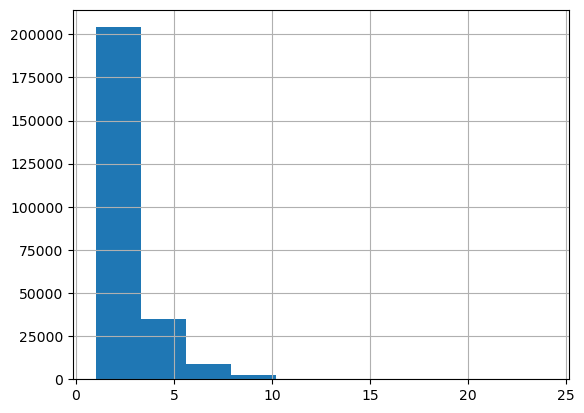

In [7]:
df[['X', 'Y']].value_counts().hist()

In [8]:
df[['X', 'Y']].value_counts().shape

(250569,)

In [9]:
df['SPECIES NAME'].unique().shape

(242,)

In [10]:
df['SPECIES NAME'].value_counts().max(), df['SPECIES NAME'].value_counts().min()

(75720, 1)

In [11]:
# remove_species = df['SPECIES NAME'].value_counts()[df['SPECIES NAME'].value_counts() < 5000].index
# remove_species.shape

In [12]:
# remove_plots = df[['X', 'Y']][df['SPECIES NAME'].isin(remove_species)]
# selected_df = df[df[['X', 'Y']].apply(tuple, axis=1).isin(remove_plots.apply(tuple, axis=1))]
# selected_df = df[df['SPECIES NAME'].isin(remove_species)]

In [13]:
# selected_df['SPECIES NAME'].value_counts()

In [14]:
grouped = df[['X', 'Y', 'SPECIES NAME']].groupby(['X', 'Y'], as_index=False).agg({'SPECIES NAME': ', '.join})

In [15]:
grouped.shape

(250569, 3)

In [16]:
grouped.head()

,X,Y,SPECIES NAME
0,1551500,1033500,Pinus radiata
1,1552500,1032500,Pinus canariensis
2,1553500,1031500,Pinus canariensis
3,1553500,1032500,Pinus canariensis
4,1554500,1031500,Pinus canariensis


In [17]:
gdf = gpd.GeoDataFrame(
    grouped.drop(labels=['X', 'Y'], axis=1), 
    geometry=gpd.points_from_xy(x=grouped.X, y=grouped.Y, crs='EPSG:3035')
)

In [18]:
gdf.head()

,SPECIES NAME,geometry
0,Pinus radiata,POINT (1551500.000 1033500.000)
1,Pinus canariensis,POINT (1552500.000 1032500.000)
2,Pinus canariensis,POINT (1553500.000 1031500.000)
3,Pinus canariensis,POINT (1553500.000 1032500.000)
4,Pinus canariensis,POINT (1554500.000 1031500.000)


In [19]:
gdf.geometry = gdf.buffer(500, cap_style=3).to_crs(epsg=4326)

In [20]:
# Add some padding to avoid border polygons being cut off.
bbox = ee.Geometry.BBox(*(gdf.geometry.total_bounds + 0.01))

In [21]:
class SentinelGetter:
    def mask_s2_clouds(self, image):
      # Quality assessment with resolution in meters
      qa = image.select('QA60')
      # Bits 10 and 11 are clouds and cirrus, respectively.
      cloud_bit_mask = 1 << 10
      cirrus_bit_mask = 1 << 11
      # Both flags should be set to zero, indicating clear conditions.
      mask = (
          qa.bitwiseAnd(cloud_bit_mask)
          .eq(0)
          .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
      )
      return image.updateMask(mask)

    def get_image(self, bbox, start_date, end_date):
        selected_bands = [f'B{x}' for x in range(2, 9)] + ['B8A', 'B11', 'B12', 'TCI_R', 'TCI_G', 'TCI_B']
        image = (
            ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate(start_date, end_date)
            # .filter(ee.Filter.calendarRange(6, 9, 'month'))
            # Pre-filter to get less cloudy granules.
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
            .map(self.mask_s2_clouds)
            .select(selected_bands)
            .median()
            .clip(bbox)
        )
        return image

In [22]:
# rgb_bands = ['B4', 'B3', 'B2']
# visualization = {
#     'min': 1,
#     'max': 3000,
#     'bands': rgb_bands
# }

# start_date = datetime.datetime(2017, 3, 1)
# end_date = datetime.datetime(2020, 3, 1)

# image = SentinelGetter().get_image(bbox, start_date, end_date)

# m = geemap.geemap.Map()

# center = (np.array(bbox.getInfo()['coordinates'][0][2]) + np.array(bbox.getInfo()['coordinates'][0][0]))/2

# m.set_center(*center, 7)

# style = {"stroke": True, "color": "green",
#          "weight": 2, "opacity": 1, "fillOpacity": 0.1
# }

# m.add_gdf(gdf.head(5000), layer_name='euforest', style=style)

# m.addLayer(image, visualization, 'RGB')

# earth_url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
# m.add_tile_layer(earth_url, name='Google Earth', attribution='Google')

# m.addLayerControl(position='topright')
# m

In [26]:
def download_npy(bbox, start_date, end_date, gdf, i):
    # Sleep time helps with parallel processing,
    # if you're brave enough to try it
    sleep_time = i*2
    sleep(sleep_time)

    # Cloud masked, band selected, mean image of the bbox area. 
    sentinel_image = SentinelGetter().get_image(bbox, start_date, end_date)
        
    # For further options, see
    # https://developers.google.com/earth-engine/apidocs/ee-data-computepixels
    params = {'fileFormat': 'NPY'}

    save_path = Path('sentinel_data').joinpath(f"euforest_{i}.npy")
    
    if save_path.is_file():
        return

    print(f'Downloading part {i}', flush=True)
    all_data = []
    
    # Progress bar, tracks continuations
    for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0]):
        # Not ideal but a lot of connection errors can occur here.
        # They are (so far) not program ending, simply retry.
        retry = True
        while retry:
            try:
                this_bbox = ee.Geometry.BBox(*row.geometry.bounds)
                params['expression'] = sentinel_image.clipToBoundsAndScale(
                    this_bbox, width=100, height=100)

                # There can be a delay before the URL becomes available,
                # in which case the loop simply retries (seems rare so far).
                pixels = ee.data.computePixels(params)
                data = np.load(io.BytesIO(pixels))

                # Numpy ndarray being appended to a list of ndarrays.
                # Ensure all_data uses python's list instead of ndarray.tolist().
                all_data.append(data)
                retry = False

            except Exception as e:
                # Sleep for 1 second if error, Google seems
                # fine with 100/s requests.
                sleep(sleep_time)
                retry = True
                
    save_data = np.array(all_data)
    with open(save_path, 'wb') as f:
        np.save(f, save_data)

In [27]:
n_chunks = 1000
chunks = [gdf[i: i + n_chunks] for i in range(0, gdf.shape[0], n_chunks)]

In [ ]:
map_inputs = []
start_date = datetime.datetime(2017, 6, 1)
end_date = datetime.datetime(2017, 10, 1)

for i, chunk in enumerate(chunks):  
    map_inputs.append((bbox, start_date, end_date, chunk, i))

pool = Pool(processes=8)
pool.starmap(download_npy, map_inputs, chunksize=1)
pool.close()
pool.join()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# encode = pd.get_dummies(df['SPECIES NAME'], dtype=float)
# group_encode = df[['X', 'Y']].join(encode).groupby(['X', 'Y'], as_index=False).max()